In [1]:
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import qutip as qt
import numpy as np
import time

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.networks import actor_distribution_network
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.environments import tf_py_environment
from tf_agents.drivers import dynamic_step_driver
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies import greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.utils import common
from tf_agents.eval import metric_utils
from absl import logging

from Plots import plot_episode
from QTransferEnv import QTransferEnv
from Noises import Noise

2023-04-30 16:53:29.325646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 16:53:29.865408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Environment Parameters

num_qubits = 3
time_max = 2
num_steps = 50
initial_state = qt.basis(num_qubits, 0)
target_state = qt.basis(num_qubits, num_qubits-1)
reward_gain = 1.0
c_ops = []
omega_min = 0
omega_max = 1
noise_type = 'gaussian'
noise_percentage = 0.05
noise_seed = None
deltas = np.zeros(num_qubits, dtype=complex)
deltas[1] = 0 - 5j

noise = Noise(noise_type, percentage=noise_percentage, seed=noise_seed)

In [3]:
# Model Hyperparameters

# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 100 # @param {type:"integer"}

initial_collect_steps = 10*num_steps # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 10*num_steps # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}
summaries_flush_secs = 10 # @param {type:"integer"}

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 100 # @param {type:"integer"}
summary_interval = 100 # @param {type:"integer"}
train_checkpoint_interval = 1000
policy_checkpoint_interval = 1000
rb_checkpoint_interval = 1000

num_eval_episodes = 100 # @param {type:"integer"}
eval_interval = 100 # @param {type:"integer"}

use_tf_functions = True # @param {type:"boolean"}
train_steps_per_iteration = num_steps

In [4]:
root_dir = "logs"

In [5]:
root_dir = os.path.expanduser(root_dir)
train_dir = os.path.join(root_dir, 'train')
eval_dir = os.path.join(root_dir, 'eval')

In [6]:
def costFunction(env: QTransferEnv):
    if env.current_step == env.num_steps - 1:
        if len(env.c_ops) == 0:
            target = qt.ket2dm(env.target_state)
            current = qt.ket2dm(env.current_qstate)
        else:
            target = env.target_state
            current = env.current_qstate
        return env.reward_gain * (qt.expect(target, current) - 2*np.max(env.populations[1]))
    return 0.0

In [7]:
env_collect_py = QTransferEnv(num_qubits=num_qubits,
                              time_max=time_max,
                              num_steps=num_steps,
                              cost_function=costFunction,
                              initial_state=initial_state,
                              target_state=target_state,
                              reward_gain=reward_gain,
                              c_ops=c_ops,
                              omega_min=omega_min,
                              omega_max=omega_max,
                              noise=noise,
                              deltas=deltas)

env_eval_py = QTransferEnv(num_qubits=num_qubits,
                           time_max=time_max,
                           num_steps=num_steps,
                           cost_function=costFunction,
                           initial_state=initial_state,
                           target_state=target_state,
                           reward_gain=reward_gain,
                           c_ops=c_ops,
                           omega_min=omega_min,
                           omega_max=omega_max,
                           noise=noise,
                           deltas=deltas)

collect_env = tf_py_environment.TFPyEnvironment(env_collect_py)
eval_env = tf_py_environment.TFPyEnvironment(env_eval_py)

In [8]:
train_summary_writer = tf.compat.v2.summary.create_file_writer(
    train_dir, flush_millis=summaries_flush_secs * 1000)
train_summary_writer.set_as_default()

eval_summary_writer = tf.compat.v2.summary.create_file_writer(
    eval_dir, flush_millis=summaries_flush_secs * 1000)

2023-04-30 16:53:33.170654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-30 16:53:33.198243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-30 16:53:33.198424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
use_gpu = True

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [10]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(collect_env))

In [11]:
with strategy.scope():
  actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [12]:
with strategy.scope():
  critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params=None,
        action_fc_layer_params=None,
        joint_fc_layer_params=critic_joint_fc_layer_params,
        kernel_initializer='glorot_uniform',
        last_kernel_initializer='glorot_uniform')

In [13]:
with strategy.scope():
  global_step = tf.compat.v1.train.get_or_create_global_step()

  tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        critic_network=critic_net,
        actor_optimizer=tf.keras.optimizers.Adam(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.keras.optimizers.Adam(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.keras.optimizers.Adam(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=global_step)

  tf_agent.initialize()

In [14]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=collect_env.batch_size,
    max_length=replay_buffer_capacity)

eval_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=eval_env.batch_size,
    max_length=num_steps + 1)

In [15]:
# Train Metrics
train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(
        buffer_size=num_eval_episodes, batch_size=collect_env.batch_size),
    tf_metrics.AverageEpisodeLengthMetric(
        buffer_size=num_eval_episodes, batch_size=collect_env.batch_size),
]

# Eval Metrics
eval_metrics = [
    tf_metrics.AverageReturnMetric(buffer_size=num_eval_episodes),
    tf_metrics.AverageEpisodeLengthMetric(buffer_size=num_eval_episodes)
]

In [16]:
eval_policy = greedy_policy.GreedyPolicy(tf_agent.policy)
initial_collect_policy = random_tf_policy.RandomTFPolicy(
    time_step_spec, action_spec)
collect_policy = tf_agent.collect_policy

In [17]:
train_checkpointer = common.Checkpointer(
    ckpt_dir=train_dir,
    agent=tf_agent,
    global_step=global_step,
    metrics=metric_utils.MetricsGroup(train_metrics, 'train_metrics'))
policy_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'policy'),
    policy=eval_policy,
    global_step=global_step)
rb_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'replay_buffer'),
    max_to_keep=1,
    replay_buffer=replay_buffer)

train_checkpointer.initialize_or_restore()
rb_checkpointer.initialize_or_restore()

In [18]:
initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    collect_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    collect_env,
    collect_policy,
    observers=[replay_buffer.add_batch] + train_metrics,
    num_steps=collect_steps_per_iteration)

eval_driver = dynamic_episode_driver.DynamicEpisodeDriver(
    eval_env,
    eval_policy,
    observers=[eval_replay_buffer.add_batch] + eval_metrics,
    num_episodes=num_eval_episodes)

In [19]:
if use_tf_functions:
    initial_collect_driver.run = common.function(initial_collect_driver.run)
    collect_driver.run = common.function(collect_driver.run)
    eval_driver.run = common.function(eval_driver.run)
    tf_agent.train = common.function(tf_agent.train)

if replay_buffer.num_frames() == 0:
    # Collect initial replay data.
    initial_collect_driver.run()

In [20]:
eval_driver.run()
metric_utils.log_metrics(eval_metrics)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
2023-04-30 16:53:42.318916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'arg_0' with dtype int32 and shape [1]
	 [[{{node arg_0}}]]
2023-04-30 16:53:42.319004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'arg_0_3' with dtype int32 and shape [1]
	 [[{{node arg_0_3}}]]
2023-04-30 16:53:42.325975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

In [21]:
time_step = None
policy_state = collect_policy.get_initial_state(collect_env.batch_size)

timed_at_step = global_step.numpy()
time_acc = 0

In [22]:
# Prepare replay buffer as dataset with invalid transitions filtered.
def _filter_invalid_transition(trajectories, unused_arg1):
    return ~trajectories.is_boundary()[0]
dataset = replay_buffer.as_dataset(
    sample_batch_size=batch_size,
    num_steps=2).unbatch().filter(
        _filter_invalid_transition).batch(batch_size).prefetch(num_steps)
# Dataset generates trajectories with shape [Bx2x...]
iterator = iter(dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
2023-04-30 16:53:55.355031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype resource
	 [[{{node Placeholder/_8}}]]


In [24]:
def train_step():
    experience, _ = next(iterator)
    return tf_agent.train(experience)

if use_tf_functions:
    train_step = common.function(train_step)

global_step_val = global_step.numpy()

In [25]:
best_population = -1
best_episode = None

In [26]:
with tf.compat.v2.summary.record_if(
      lambda: tf.math.equal(global_step % summary_interval, 0)):
    while global_step_val < num_iterations:
      start_time = time.time()
      time_step, policy_state = collect_driver.run(
          time_step=time_step,
          policy_state=policy_state,
      )
      for _ in range(train_steps_per_iteration):
        train_loss = train_step()
      time_acc += time.time() - start_time

      global_step_val = global_step.numpy()

      if log_interval and global_step_val % log_interval == 0:
        logging.info('step = %d, loss = %f', global_step_val,
                     train_loss.loss)
        steps_per_sec = (global_step_val - timed_at_step) / time_acc
        logging.info('%.3f steps/sec', steps_per_sec)
        tf.compat.v2.summary.scalar(
            name='global_steps_per_sec', data=steps_per_sec, step=global_step)
        timed_at_step = global_step_val
        time_acc = 0

      for train_metric in train_metrics:
        train_metric.tf_summaries(
            train_step=global_step, step_metrics=train_metrics[:2])

      if eval_interval and global_step_val % eval_interval == 0:
        eval_metrics[0].reset()
        eval_driver.run()
        if best_population < eval_metrics[0].result().numpy():
            best_population = eval_metrics[0].result().numpy()
            best_episode = eval_replay_buffer.gather_all()
        metric_utils.log_metrics(eval_metrics)
        with eval_summary_writer.as_default():
            tf.compat.v2.summary.scalar(
                name='best_population', data=best_population, step=global_step)

      if train_checkpoint_interval and global_step_val % train_checkpoint_interval == 0:
        train_checkpointer.save(global_step=global_step_val)

      if policy_checkpoint_interval and global_step_val % policy_checkpoint_interval == 0:
        policy_checkpointer.save(global_step=global_step_val)

      if rb_checkpoint_interval and global_step_val % rb_checkpoint_interval == 0:
        rb_checkpointer.save(global_step=global_step_val)

2023-04-30 16:54:01.544699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'arg_0' with dtype int32 and shape [1]
	 [[{{node arg_0}}]]
2023-04-30 16:54:01.544787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'arg_0_3' with dtype int32 and shape [1]
	 [[{{node arg_0_3}}]]
2023-04-30 16:54:01.551708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'driver_loop/Placeholder_1' with dtype int32 and shape [1]
	 [[{{node driver_loop/Placehol

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Population 3: 0.0069602602161467075
Total population: 0.8529614806175232


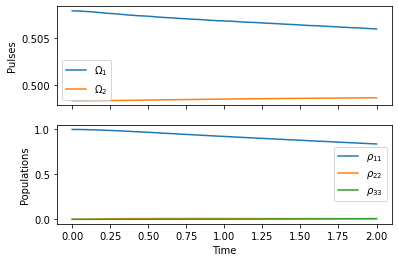

In [27]:
times = env_eval_py.times
plot_episode(times, best_episode)
print("Population {}: {}".format(num_qubits, best_episode.observation.numpy()[0, -1, num_qubits - 1]))
print("Total population: {}".format(np.sum(best_episode.observation.numpy()[0, -1, :num_qubits])))

In [28]:
actions = []
time_step = eval_env.reset()
while not time_step.is_last():
    action_step = eval_driver.policy.action(time_step)
    time_step = eval_env.step(action_step.action)
    actions.append(action_step.action.numpy()[0])
actions = np.array(actions)

In [29]:
times = env_eval_py.times
plot_pulses(times[:-1], actions)

NameError: name 'plot_pulses' is not defined